This homework will guide you through a complete additive model analysis of a time series and familiarize you with the (fairly new) [Facebook Prophet](https://facebook.github.io/prophet/) package for time series analysis. 

Prophet simplifies the implementation of analysis like "Structural Time Series modeling" and/or "Bayesian dynamic linear model": similarly to the ARMA family of models, these models attempt to recreate (and predict) a time series by linearly combining variouos components: trends, seasonalities, but also regression on exogenous variables. In this case, we will see if Uber rides area affected by weather, in additional to trends and seasonality. 

Under the hood, the model will implement an optimization to find the best fit parameters for each component (mostly the relative amplitude of each component) in a Bayesian framework, either as a direct optimization which is possible since the model is linear, or by MCMC (https://github.com/facebook/prophet/issues/669)

Note that the 4 models you will create build incrementally: you are always adding one more piece of a model to the previous one (even when it is not explicitly stated that the new model contains all the components of the previous ones:
- Model 1: trend and seasonality
- Model 2: trend, seasonality, and exogenous weather variables
- Model 3: trend, seasonality, exogenous weather variables, holidays
- Model 4: trend, seasonality, exogenous weather variables, holidays, MCMC implementation (same model, different optimization)



In [177]:
import pandas as pd
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


 
# DATA ANALYSIS 0: we will use the package Prohpet, created by facebook for time series analysis. 
Install the package and import it. The model that you will use is Prophet. Also import the diagnostics package from fbprophet


In [178]:
!pip install fbprophet


In [0]:
import fbprophet

In [0]:
from fbprophet import Prophet
from fbprophet import diagnostics

# 1. DATA ACQUISITION 1: write a for loop that extracts files from the repository https://github.com/fivethirtyeight/uber-tlc-foil-response. 

There are a number of csv files in the repository, and a zip file. Read in within the loop the 6 csv files representing uber pickup deives from April to September 2014. This can be done with a for loop iterating in a container that contains the apporopriate string identified in the file names (e.g. 'apr' for April) and composes the string using an immutable root, the month name, and the immutable ending of the file. Remember to read in the raw files. Remember that ```pd_read_csv ()``` accepts URLs, so you do not have to download the data.

At the end you need the data to be appended into a single datafraom (note: appended, i.e. concatenated, not merged.) You can achieve this in many ways, an easy (and a bit lazy one) is to append each file read in as a dataframe to a list and use ```pd.concat(list)``` to concatenate them into a single dataframe.

In [0]:
####Loop for loading in the uber-trip data
a = []
for mon in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']:
     data_in = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-' 
                           + mon + '14.csv' )
     a.append(data_in)

In [0]:
#concatenates the data
uberrides = pd.concat(a)
#print(uberrides)

# DATA PREPARATION 1: convert the dates to datetime and generate a time series of rides/day. 
Note that at this stage this is not the kind of time series you need. You need number of rides per unit time (e.g. per day) and we have timsetamp of each ride. 
To obtain that you can use the ```groupby()``` method of your dataframe. Before that, convert the date time column to ```pd.datetime``` type (this may take a while), then you can use groupby with the "date" attribute, which means grouping by day, and use the method count of groupby to count the number of rides in each group. 

Finally, rename the dataframe so that the number of rides is column ```y``` and the dates are column ```ds``` - this is required by the prophet package that you will use for the enalysis.

** plot the resulting dataframe

In [183]:
uberrides['Date/Time'] = pd.to_datetime(uberrides['Date/Time']) 
print(uberrides)

                  Date/Time      Lat      Lon    Base
0       2014-04-01 00:11:00  40.7690 -73.9549  B02512
1       2014-04-01 00:17:00  40.7267 -74.0345  B02512
2       2014-04-01 00:21:00  40.7316 -73.9873  B02512
3       2014-04-01 00:28:00  40.7588 -73.9776  B02512
4       2014-04-01 00:33:00  40.7594 -73.9722  B02512
...                     ...      ...      ...     ...
1028131 2014-09-30 22:57:00  40.7668 -73.9845  B02764
1028132 2014-09-30 22:57:00  40.6911 -74.1773  B02764
1028133 2014-09-30 22:58:00  40.8519 -73.9319  B02764
1028134 2014-09-30 22:58:00  40.7081 -74.0066  B02764
1028135 2014-09-30 22:58:00  40.7140 -73.9496  B02764

[4534327 rows x 4 columns]


In [184]:
uberrides.iloc[0]["Date/Time"].date

<function Timestamp.date>

In [0]:
####converting individual time stamped rides into counts for a given day
uberbyday = uberrides.groupby(uberrides["Date/Time"].dt.date) 

uberbyday = uberbyday.count()


In [0]:
uberbyday.rename(columns={'Date/Time': 'y'}, inplace=True )   
uberbyday.reset_index(inplace=True) 



In [187]:
####this was a needed step, becasue python wasn't renaming the columns properly.
uberbyday2 = uberbyday.rename(columns={'Date/Time': 'ds'})
print(uberbyday2)


             ds      y    Lat    Lon   Base
0    2014-04-01  14546  14546  14546  14546
1    2014-04-02  17474  17474  17474  17474
2    2014-04-03  20701  20701  20701  20701
3    2014-04-04  26714  26714  26714  26714
4    2014-04-05  19521  19521  19521  19521
..          ...    ...    ...    ...    ...
178  2014-09-26  37504  37504  37504  37504
179  2014-09-27  39468  39468  39468  39468
180  2014-09-28  29656  29656  29656  29656
181  2014-09-29  29201  29201  29201  29201
182  2014-09-30  33431  33431  33431  33431

[183 rows x 5 columns]


Text(0.5, 0, 'ds (Dates)')

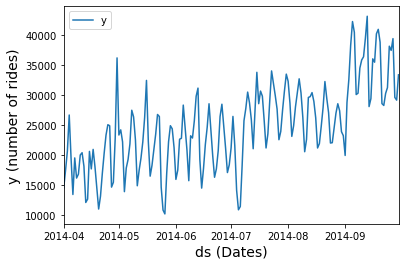

In [190]:

ax = uberbyday2.plot(x="ds", y="y")
ax.set_ylabel('y (number of rides)', fontsize = 14)
ax.set_xlabel('ds (Dates)', fontsize = 14)

**Figure 1:** Above is the time series for number of uber rides taken  from April 1st, 2014 to September 30th, 2014, plotted by date. This the time series that will be used in our analysis and fitting with the Prophe modeling package.  

# DATA PREPARATION 2: stanardize the data
Subtract the mean and divide by the standard eviation the ```y``` column. Although this is not strictly necessary to work with the Prophet package, it is in general recommanded not to use large numbers in your analysis. furtehrmore, this will convert the target variable to a floating point, which is a better type for regression

Text(0.5, 0, 'ds (Dates)')

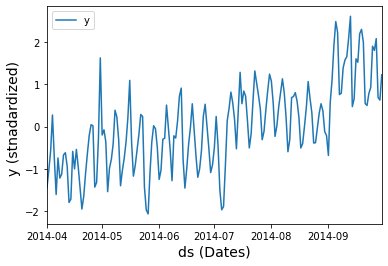

In [191]:
uberbyday2['y'] = (uberbyday2['y'] - uberbyday2['y'].mean())/ (uberbyday2['y'].std())
ax = uberbyday2.plot(x="ds", y="y")
ax.set_ylabel('y (stnadardized) ', fontsize = 14)
ax.set_xlabel('ds (Dates)', fontsize = 14)

**Figure 2:** This is the same time series as above, however the data has been standardized, where mean number of uber rides is subtracted from each data point, and that difference is normalized by the standardard deviation. 

# DATA ANALYSIS fit the uber rides data with the prophet model. 
# MODEL 1: trends and seasonality
The model will look for seasonality and trends automatically. It is a bit of a black box and I dont have a lot of experience with it, but it is really "cutting edge" in this field.
As with any object oriented package, you first need to invoke ```Phrophet()``` to create a model, call it ```simplem```, then fit it to the uber data. Forecast 1 month past the last available datapoint and print the last 5 entries of the resulting dataframe. Plot the forecast, including the uncertainty regions of the forecast and the comonents of the forcast which should be the trend and the weekly seanality. The model should naturally produce these components. If it does not look into the model and the settings by displaying the model methods (e.g. type ```siplemodel.``` and press the tab key.) Remember that ou MUST describe what you see in these plots!


In [192]:
####implement the modeling from Prophet, and fit it on the uber-data
simplem = Prophet()
simplem.fit(uberbyday2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [193]:
###make a forcast using the model  
future = simplem.make_future_dataframe(periods=30)
forecast = simplem.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
208,2014-10-26,0.671657,0.006365,1.347326
209,2014-10-27,0.950767,0.340977,1.581945
210,2014-10-28,1.528120,0.900787,2.156878
211,2014-10-29,1.885666,1.260603,2.558598
212,2014-10-30,2.204848,1.526909,2.883063


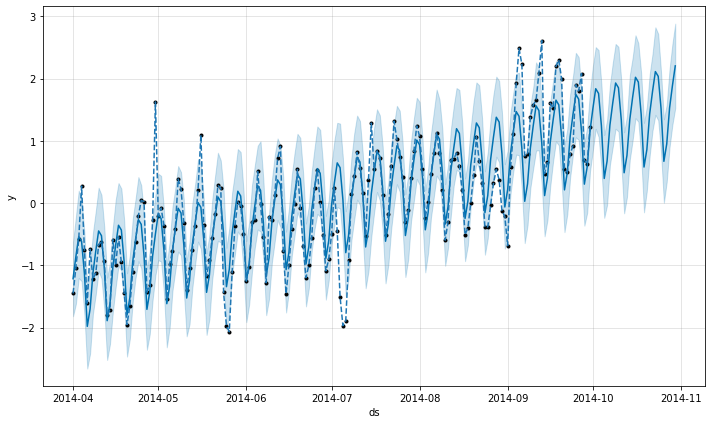

In [194]:
####plotting the simple model 
fig1 = simplem.plot(forecast)
pl.plot(uberbyday2['ds'], uberbyday2['y'], '--');

**Figure 3:** Above is the uber-ride time series plotted with the model generated by **Prophet() **. A dashed line is also used to connect the orignal data points.  The model is then extended and the forcast-predictions are plotted as well for a month, after the last data point. As we see the model holds to the period and on-average increasing trend, it extracted from the data.

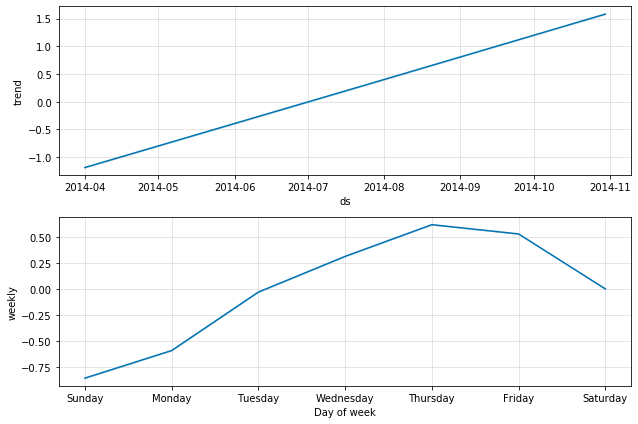

In [195]:
fig2 = simplem.plot_components(forecast)


**Figure 4:** Above are the trend and weekly seasonality, which are components of the model shown in Figure 3. 

# DATA ANALYSIS: model validatoin
 Crossvaliate your model and create a function to evaluate the goodness of fit of your model. 
Use the chisquare per degree of freedom (also calle reduced chi square, note that this quantity has a theoretical expectation value of 1 for a perfect model): the chi square divided by the number of observations.Use 30 days for crossvalidation. The diagnostics function will return all that you need to calculate your reduce chi2. Howeve, we o not have the uncertainties to put them in the formula (we could create them from count statistics, but I wont ask you to) so set the uncertainties to 1. With unerestimated uncertainties this quantity is likely to be less than 1.

You can read about cross valiation for regression here https://robjhyndman.com/hyndsight/tscv/ (but do not set the period=1 or the process would take too long)

In [196]:
####the cross_validation of the data, can specify the window of cutoff to horizon if needed
cvresult_simplem = diagnostics.cross_validation(simplem, horizon='30 days')


INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [197]:
print(cvresult_simplem)

            ds      yhat  yhat_lower  yhat_upper         y     cutoff
0   2014-07-03  0.474445   -0.050101    1.015115 -0.450615 2014-07-02
1   2014-07-04  0.474838   -0.071595    1.010523 -1.505913 2014-07-02
2   2014-07-05 -0.263004   -0.793023    0.262115 -1.967473 2014-07-02
3   2014-07-06 -1.073989   -1.603027   -0.534169 -1.889129 2014-07-02
4   2014-07-07 -0.722523   -1.258040   -0.175692 -0.920533 2014-07-02
..         ...       ...         ...         ...       ...        ...
145 2014-09-26  1.159241    0.556491    1.736319  1.802925 2014-08-31
146 2014-09-27  0.540499   -0.099951    1.130929  2.081164 2014-08-31
147 2014-09-28 -0.165955   -0.777752    0.447704  0.691101 2014-08-31
148 2014-09-29  0.185216   -0.382527    0.763450  0.626642 2014-08-31
149 2014-09-30  0.710284    0.111684    1.286109  1.225904 2014-08-31

[150 rows x 6 columns]


In [0]:
####function for calculating the reduced chi-square
####since they are operated on by index and scaled by the total lenght of the array 
#####we can use the mean in our function 
def rchi2(y, ytrue):
    y, ytrue = np.array(y), np.array(ytrue)
    return np.mean((ytrue - y )**2.0/ 1.0) 


In [199]:
chi_sq_simplem = rchi2(cvresult_simplem.yhat, cvresult_simplem.y)
print("The Chi-Square for this model is " + str(chi_sq_simplem ))

The Chi-Square for this model is 0.4602355257526829


# DATA ACQUISITION 2: dooownload exogenous variable data. 
One may guess that weather would affect the number of rides: a trivial example is that if it rains people are less likely to walk. It might not be that trivial tho, maybe if it  rains people are altogether less likely to go out.

Acquire weather data for NYC for the relevant time period from the www.worldweatheronline.com website through the wwo_hist API. You will have to 1) request a key https://www.worldweatheronline.com/developer/api/, https://www.worldweatheronline.com/developer/signup.aspx ( it is free for <500 requests).
an install and import the ```wwo_hist``` package

Save your key in a separate file and read it in. For example, you can create a file ```my_apis.csv``` in the same folder where you are working and the content of the file can be ```wwo,XXXXXXXXXXXXXXXXX```

This should download a ```New+york,ny.csv``` file which you can then read in. Convert the atetime entry to pd.datetime as you did before and merge the uber reides and the weather dataframe on the date feature. YOud rataframe should now have columns ```y, ds, tempC, precipMM```. You should stanardize the tempC and precipMM features as you did for the number of rides.

Plot each feature.

In [200]:
!pip install wwo_hist

In [0]:
from wwo_hist import retrieve_hist_data

In [202]:
from google.colab import drive

drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [203]:
cd gdrive/My\ Drive

[Errno 2] No such file or directory: 'gdrive/My Drive'
/content/gdrive/My Drive


In [22]:
######this can be skiped as long as the data has been acquired. 
frequency = 24
start_date = '2014-04-01'
end_date = '2014-09-30'
api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)



Retrieving weather data for New+york,ny


Currently retrieving data for New+york,ny: from 2014-04-01 to 2014-04-30


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Time elapsed (hh:mm:ss.ms) 0:00:00.958276
Currently retrieving data for New+york,ny: from 2014-05-01 to 2014-05-31
Time elapsed (hh:mm:ss.ms) 0:00:01.967860
Currently retrieving data for New+york,ny: from 2014-06-01 to 2014-06-30
Time elapsed (hh:mm:ss.ms) 0:00:02.998177
Currently retrieving data for New+york,ny: from 2014-07-01 to 2014-07-31
Time elapsed (hh:mm:ss.ms) 0:00:03.918779
Currently retrieving data for New+york,ny: from 2014-08-01 to 2014-08-31
Time elapsed (hh:mm:ss.ms) 0:00:04.907162
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:05.943280
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:06.841325


export New+york,ny completed!




In [204]:
weather = pd.read_csv("New+york,ny.csv")
print(weather) 

      date_time  maxtempC  mintempC  ...  visibility  winddirDegree  windspeedKmph
0    2014-04-01        12         2  ...          10            269             11
1    2014-04-02        12         4  ...           9            208              6
2    2014-04-03        13         6  ...          10            209              7
3    2014-04-04         6         5  ...           9             96             15
4    2014-04-05        10         3  ...           9            259             19
..          ...       ...       ...  ...         ...            ...            ...
208  2014-09-26        23        13  ...          10             58             11
209  2014-09-27        25        15  ...          10            161              7
210  2014-09-28        26        15  ...          10            206              6
211  2014-09-29        24        17  ...          10            248              6
212  2014-09-30        21        17  ...           7            146              8

[21

In [205]:
###all of this is done to get the dataframe to be compatible with the uberbyday 
####array. It was really trial and error, so i stuck with what worked. 
weather['date_time'] = pd.to_datetime(weather['date_time']) 
weather2 = weather[0:183]
weather2['date_time'] = pd.to_datetime(weather2['date_time']) 
weather3= weather2.rename(columns={'date_time': 'ds'})


print(weather3)


            ds  maxtempC  mintempC  ...  visibility  winddirDegree  windspeedKmph
0   2014-04-01        12         2  ...          10            269             11
1   2014-04-02        12         4  ...           9            208              6
2   2014-04-03        13         6  ...          10            209              7
3   2014-04-04         6         5  ...           9             96             15
4   2014-04-05        10         3  ...           9            259             19
..         ...       ...       ...  ...         ...            ...            ...
178 2014-09-26        23        13  ...          10             58             11
179 2014-09-27        25        15  ...          10            161              7
180 2014-09-28        26        15  ...          10            206              6
181 2014-09-29        24        17  ...          10            248              6
182 2014-09-30        21        17  ...           7            146              8

[183 rows x 25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
###merging the two arrays, however couldn't get rid of the unwanted columns. 

uberbyday2['ds'] = pd.to_datetime(uberbyday2['ds']) 
uberweather = uberbyday2.merge(weather3, on='ds' ) 

                            

In [207]:
####the full weather/uber array
uberweather

,ds,y,Lat,Lon,Base,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2014-04-01,-1.449528,14546,14546,14546,12,2,0.0,12.8,1,1,5,06:41 AM,08:41 PM,05:40 AM,06:21 PM,4,6,8,6,16,10,77,0.0,1019,12,10,269,11
1,2014-04-02,-1.034719,17474,17474,17474,12,4,0.0,12.8,1,1,13,07:21 AM,09:44 PM,05:38 AM,06:22 PM,5,7,8,7,10,27,83,0.2,1019,12,9,208,6
2,2014-04-03,-0.577551,20701,20701,20701,13,6,0.0,12.9,1,1,21,08:03 AM,10:41 PM,05:37 AM,06:23 PM,6,9,10,9,12,23,75,0.0,1018,13,10,209,7
3,2014-04-04,0.274309,26714,26714,26714,6,5,0.0,8.1,1,1,28,08:49 AM,11:34 PM,05:35 AM,06:24 PM,4,3,6,3,22,95,87,4.5,1015,6,9,96,15
4,2014-04-05,-0.744721,19521,19521,19521,10,3,0.0,12.9,1,1,36,09:38 AM,No moonset,05:33 AM,06:25 PM,2,3,7,3,29,29,76,0.1,1012,10,9,259,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2014-09-26,1.802925,37504,37504,37504,23,13,0.0,11.6,1,1,12,08:02 AM,07:04 PM,05:48 AM,05:47 PM,15,19,20,19,16,4,75,0.0,1022,23,10,58,11
179,2014-09-27,2.081164,39468,39468,39468,25,15,0.0,11.6,1,1,19,09:02 AM,07:41 PM,05:49 AM,05:45 PM,18,23,24,23,9,0,78,0.0,1022,25,10,161,7
180,2014-09-28,0.691101,29656,29656,29656,26,15,0.0,11.6,1,1,27,10:02 AM,08:23 PM,05:50 AM,05:43 PM,18,23,24,23,11,14,76,0.0,1019,26,10,206,6
181,2014-09-29,0.626642,29201,29201,29201,24,17,0.0,8.8,1,1,34,11:01 AM,09:12 PM,05:51 AM,05:42 PM,15,21,21,21,11,60,70,0.1,1014,24,10,248,6


Text(0.5, 0, 'ds')

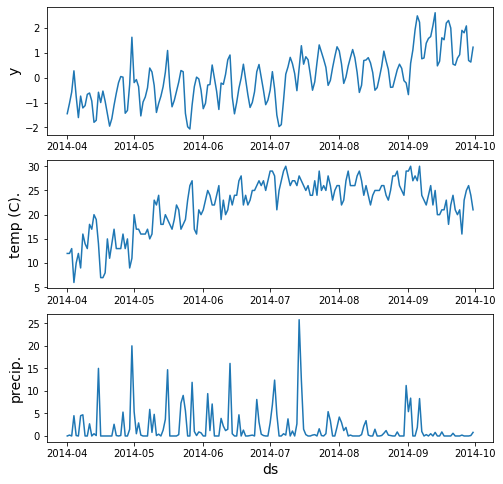

In [208]:
fig, ax = pl.subplots(3 , figsize=(8,8))
ax[0].plot(uberweather["ds"], uberweather["y"], )
ax[0].set_ylabel('y', fontsize=14)

ax[1].plot(uberweather["ds"], uberweather["tempC"])
ax[1].set_ylabel('temp (C).', fontsize=14)

ax[2].plot(uberweather["ds"], uberweather["precipMM"]) 
ax[2].set_ylabel('precip.', fontsize=14)
ax[2].set_xlabel('ds', fontsize=14)

Figure 5: Above are three time series, for standardized uber-rides, temperature,and precipitation levels, of the same time axis in units of date. We extend our modeling capabilities of uber ride trends by acquiring weather data, temperature and precipitation, which will allow us to regress models, under the assumption weather would impact uber usage.

   # MODEL 2: create a new Prophet model and add to it tempC and precipMM as regressors
Use the model method ```model.add_regressor()```. Call the model ```regrm```. Fit the model and cross valiate it. Plot the 2 models and calculate the reduced chi2 for each model and compare. Note that here you should not forecast, since you do not have the future values of the weather. If you wanted to go through the trouble to get future weather and forecast that is definitely a good extra credit!

In [209]:
###including regression on the data based on weather. 
regrm = Prophet() 
regrm.add_regressor('tempC')
regrm.add_regressor('precipMM')


In [210]:
regrm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


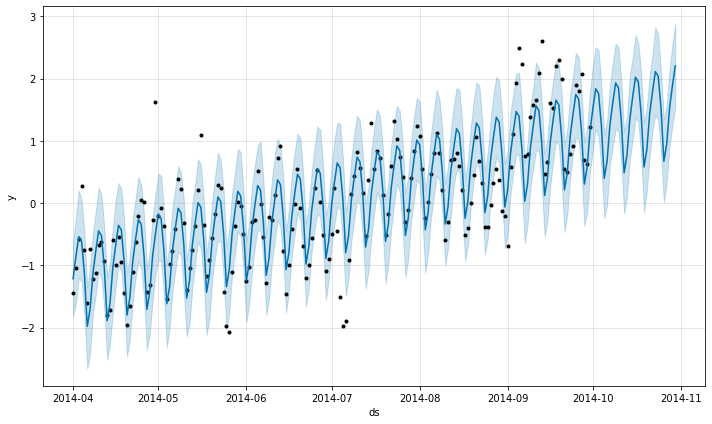

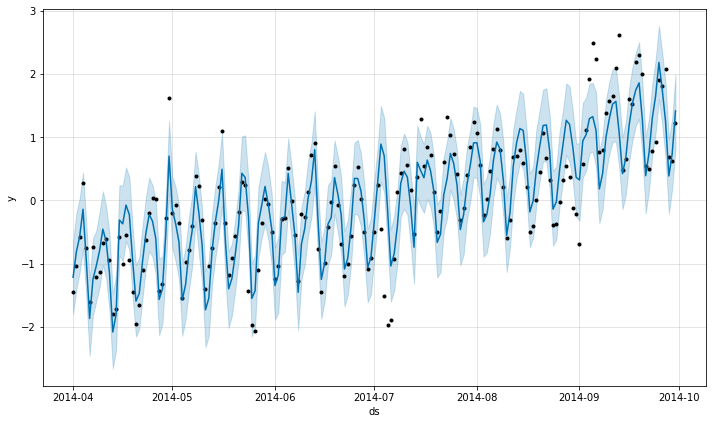

In [211]:
###plotting the two models 
####models that rely's on data can't forcecast without additional weather data 
nowcast = regrm.predict()
simplem.plot(forecast)
regrm.plot(nowcast);


Figure 6: The top figure is the simple Prophet model on the uber-rides data. Below it, is the models with regressions included for weather, particularly temperature and precipitation. As seen, this model lets go of some of the oscillatory trend and one can pick out tendency towards high peaks (i.e. ride ussage is above the over all average) on rainy and cooler days. 

In [212]:
cvresult_regrm = diagnostics.cross_validation(regrm, horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [214]:
chi_sq_regrm = rchi2(cvresult_regrm.yhat, cvresult_regrm.y)
print(chi_sq_regrm)

0.45424306254031954


# MODEL 3 add holidays
Holiday of course affect traffic and ridership. Prophoet has very convenient functionality to put in holidays! This a huge simplification of the workflow in timeseries analysis! add holidays for ths us with the model ```model.add_country_holidays()``` which takes argument ```country_name="US"``` in the case of the US. Once again, fit, predict, plot, crossvalidate, calculate and compare the reduced chi2


In [215]:
regholm = Prophet() 
regholm.add_regressor('tempC')
regholm.add_regressor('precipMM')
regholm.add_country_holidays(country_name ="US") 
regholm.fit(uberweather)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
nowcast2 = regholm.predict() 

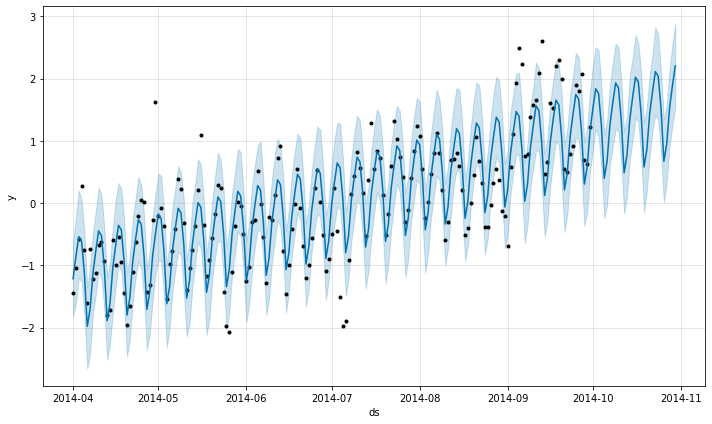

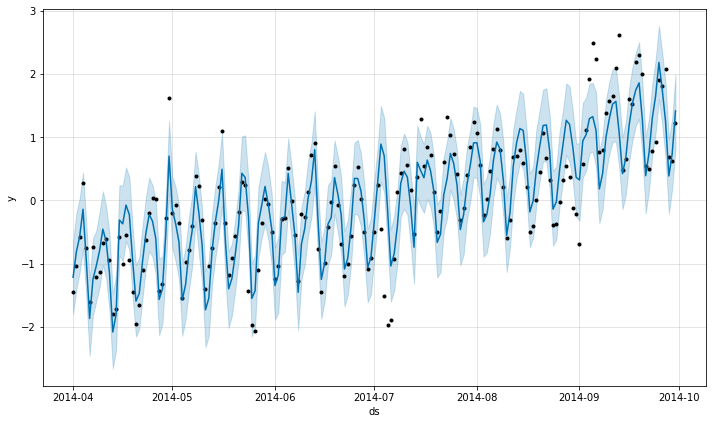

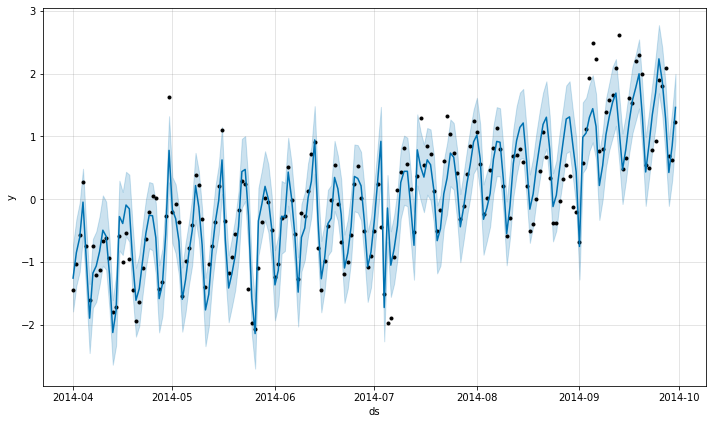

In [217]:
simplem.plot(forecast)
regrm.plot(nowcast)
regholm.plot(nowcast2);

Figure 7: The two above are the prior models discussed. In the bottom plot is the next itteration on the Prophet Model, where we incorporate regression based holidays, under the assumpstion they could impact uber ussage. As we see the incoporation of holidays brings the model bring models significantly close to the values that are lower than the over all trend, (the sharp dips), which line up with holiday like Memorial Day, Independence Day, and Labor Day. 

In [218]:
cvresult_regholm = diagnostics.cross_validation(regholm, horizon='30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [219]:
chi_sq_regholm = rchi2(cvresult_regholm.yhat, cvresult_regholm.y)
print(chi_sq_regholm)

0.38351670323380993


# MODEL 4: this whole thing can be done with MCMC optimization in a fully bayesian framework. 
Add the argument mcmc_samples=5000 to Propher in your next model and see how it goes. Make the usual plots and calculate the reduced chi2 one last time

In [220]:
regmcmc = Prophet(mcmc_samples=5000)
regmcmc.add_regressor('tempC')
regmcmc.add_regressor('precipMM')
regmcmc.add_country_holidays(country_name ="US") 
regmcmc.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
nowcast3 = regmcmc.predict() 


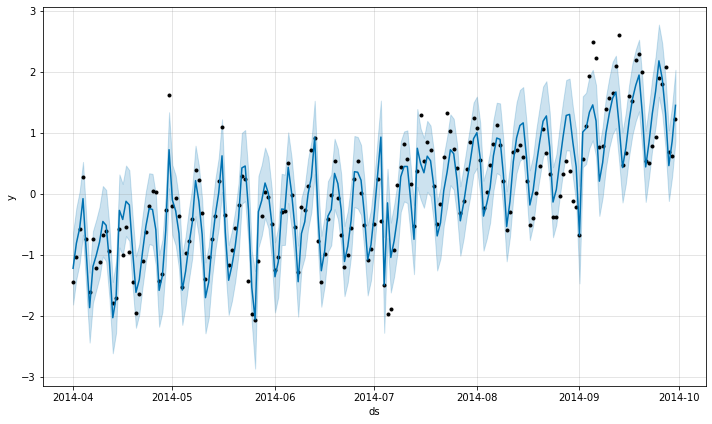

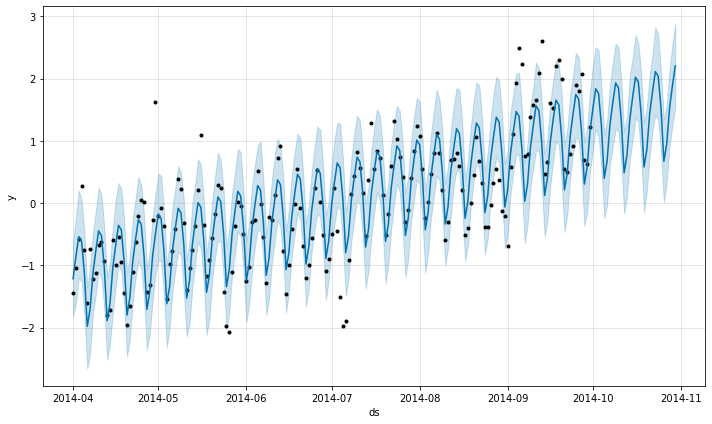

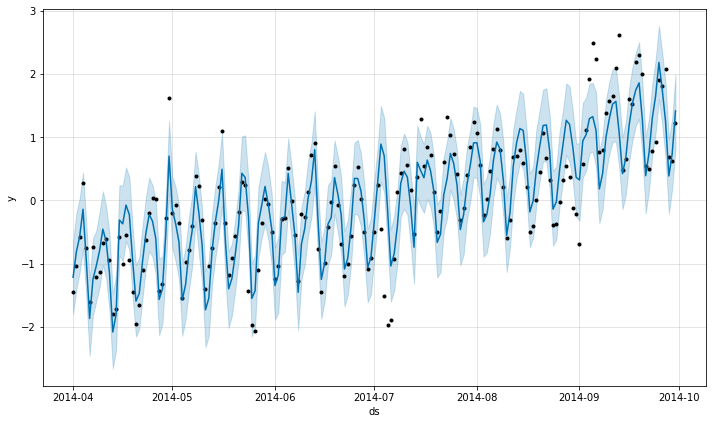

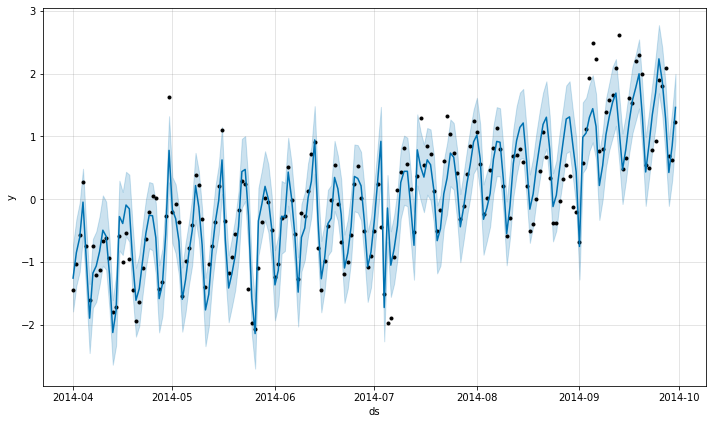

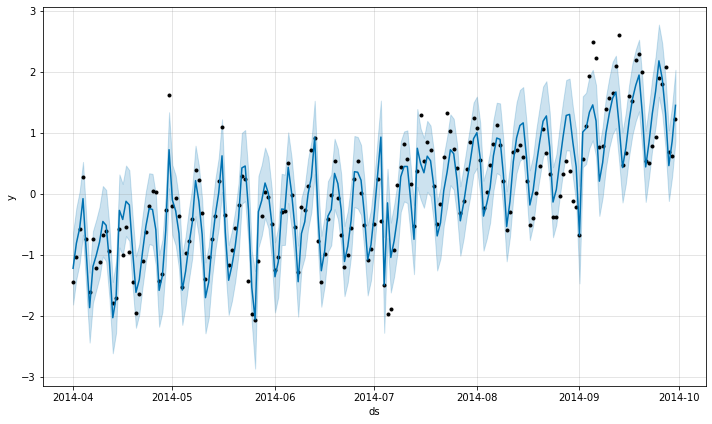

In [222]:
simplem.plot(forecast)
regrm.plot(nowcast)
regholm.plot(nowcast2)
regmcmc.plot(nowcast3)

**Figure 8:** In the figure the top three plots are of the models prior to this section, going down in the order as we have executed them. The bottom plot is of the fourth itteration on the Prophet Model, with other conditions still applied, where we uses Monte Carlo Markov Chain methods to sample the data, allowing us to understand what the seasonal uncertainty is like. 

In [223]:
cvresult_regmcmc = diagnostics.cross_validation(regmcmc, horizon='30 days')



INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [225]:
chi_sq_mcmc = rchi2(cvresult_regmcmc.yhat, cvresult_regmcmc.y)


print('The chi-squares are...') 
print('Simple Prophet             ' + str(chi_sq_simplem))
print('+ Resgression on Weather   ' + str(chi_sq_regrm))
print('+ Resgression on Holidays  ' + str(chi_sq_regholm))
print('+ MCMC Sampling            ' + str(chi_sq_mcmc))




The chi-squares are...
Simple Prophet             0.4602355257526829
+ Resgression on Weather   0.45424306254031954
+ Resgression on Holidays  0.38351670323380993
+ MCMC Sampling            0.44738021907843917


# Extra Credit
There are two packages with similar functionalities. As extra credit, repeat some of the steps of this analysis with either: Tensorflow timeseries modeling https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html or https://github.com/wwrechard/pydlm